In [2]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from uncprop.models.vsem.experiment import summarize_rep, load_results
from uncprop.utils.plot import set_plot_theme, smart_subplots
from uncprop.utils.grid import plot_coverage_curve_reps

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
output_dir = base_dir / 'out' / 'final'

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read experiment output

out_dir = base_dir / 'out' / 'vsem'
gp_subdirs = ['gp_N4', 'gp_N8', 'gp_N16']
clip_gp_subdirs = ['clip_gp_N4', 'clip_gp_N8', 'clip_gp_N16']

gp_results = load_results(out_dir, gp_subdirs)
clip_gp_results = load_results(out_dir, clip_gp_subdirs)

results = {'gp': gp_results, 'clip_gp': clip_gp_results}

### Coverage Plots

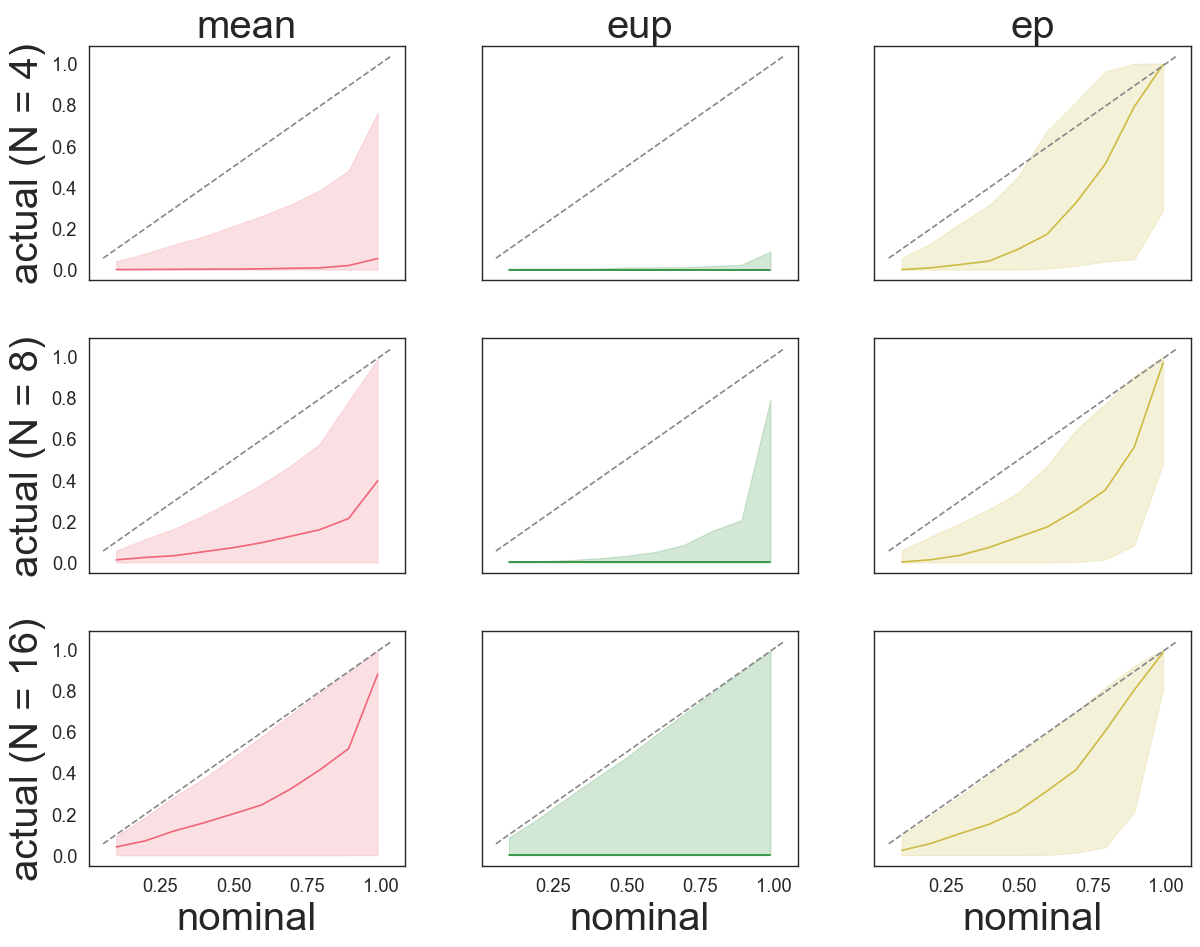

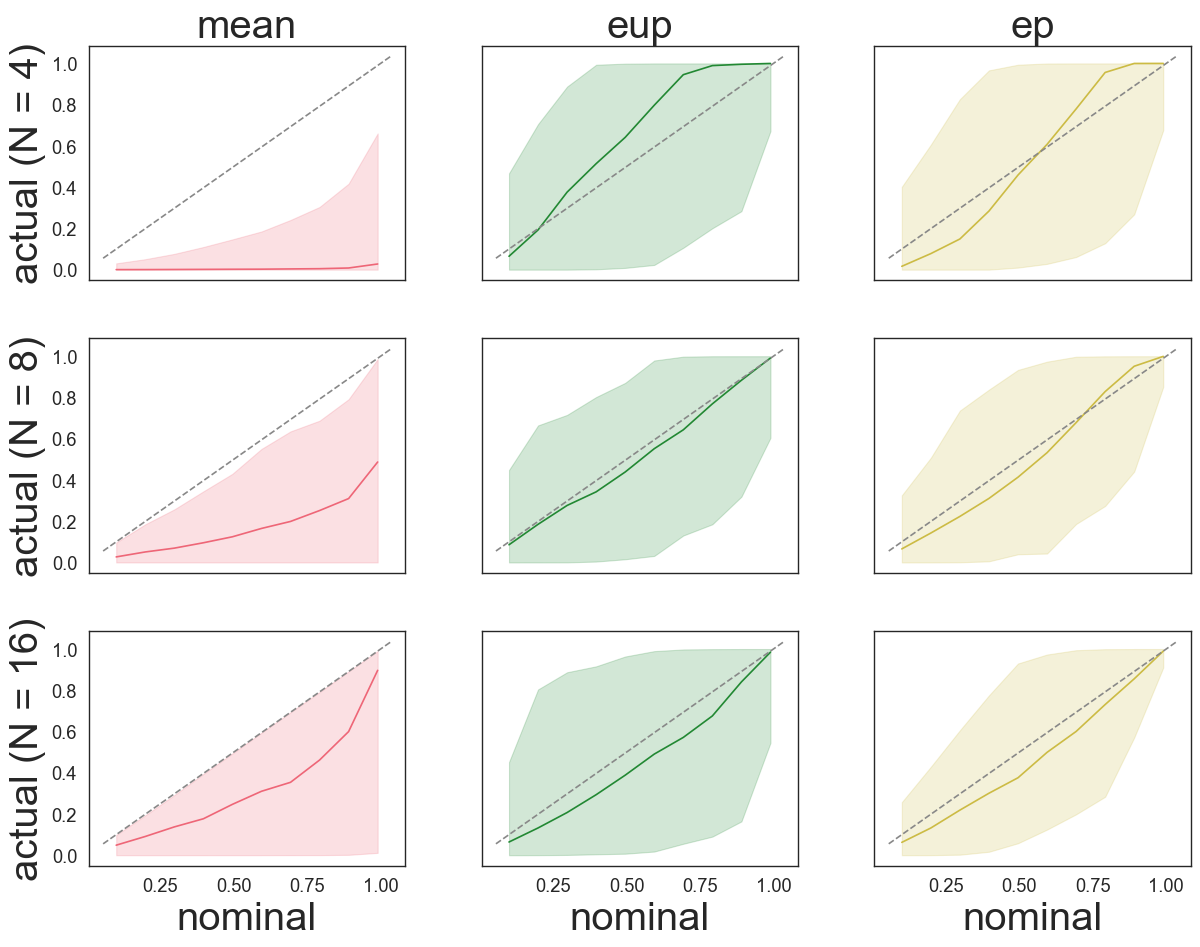

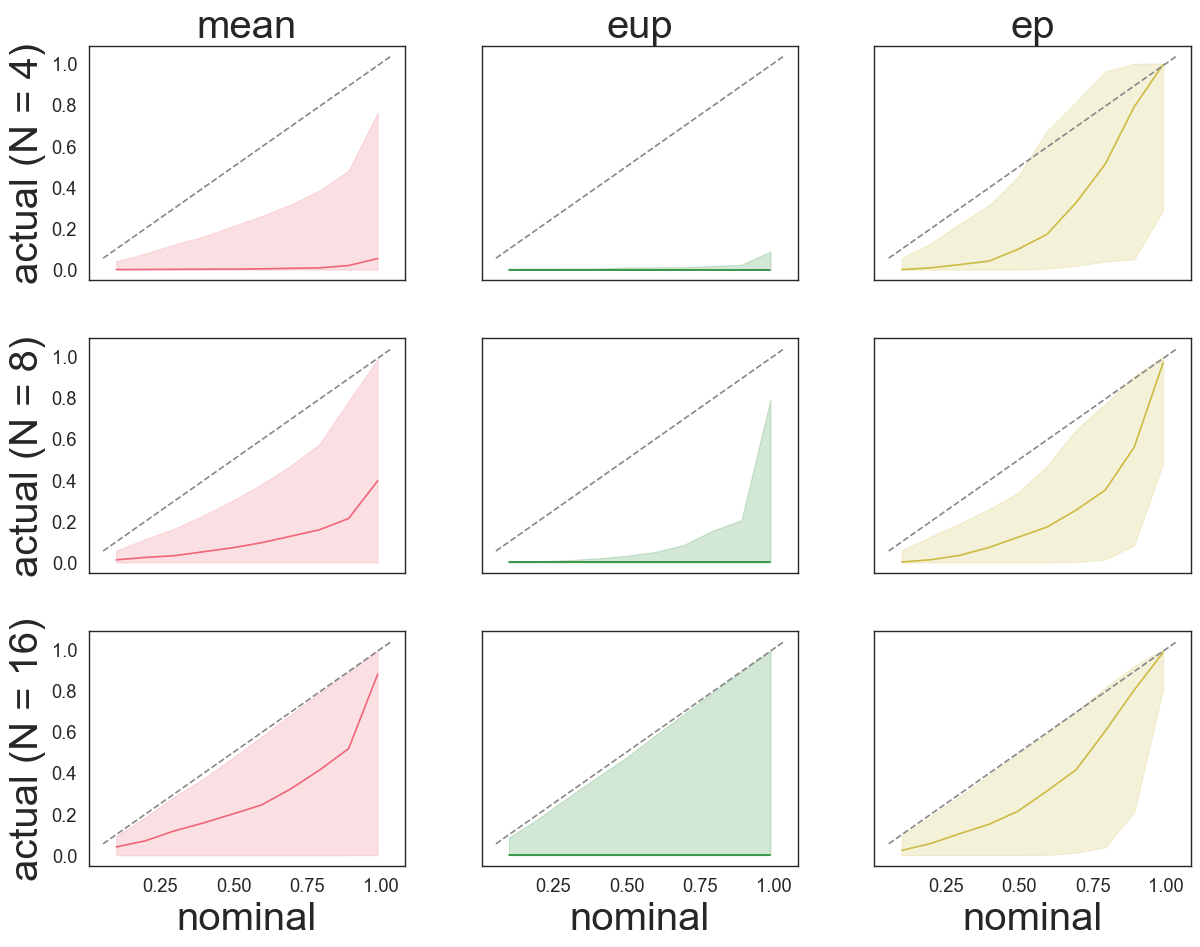

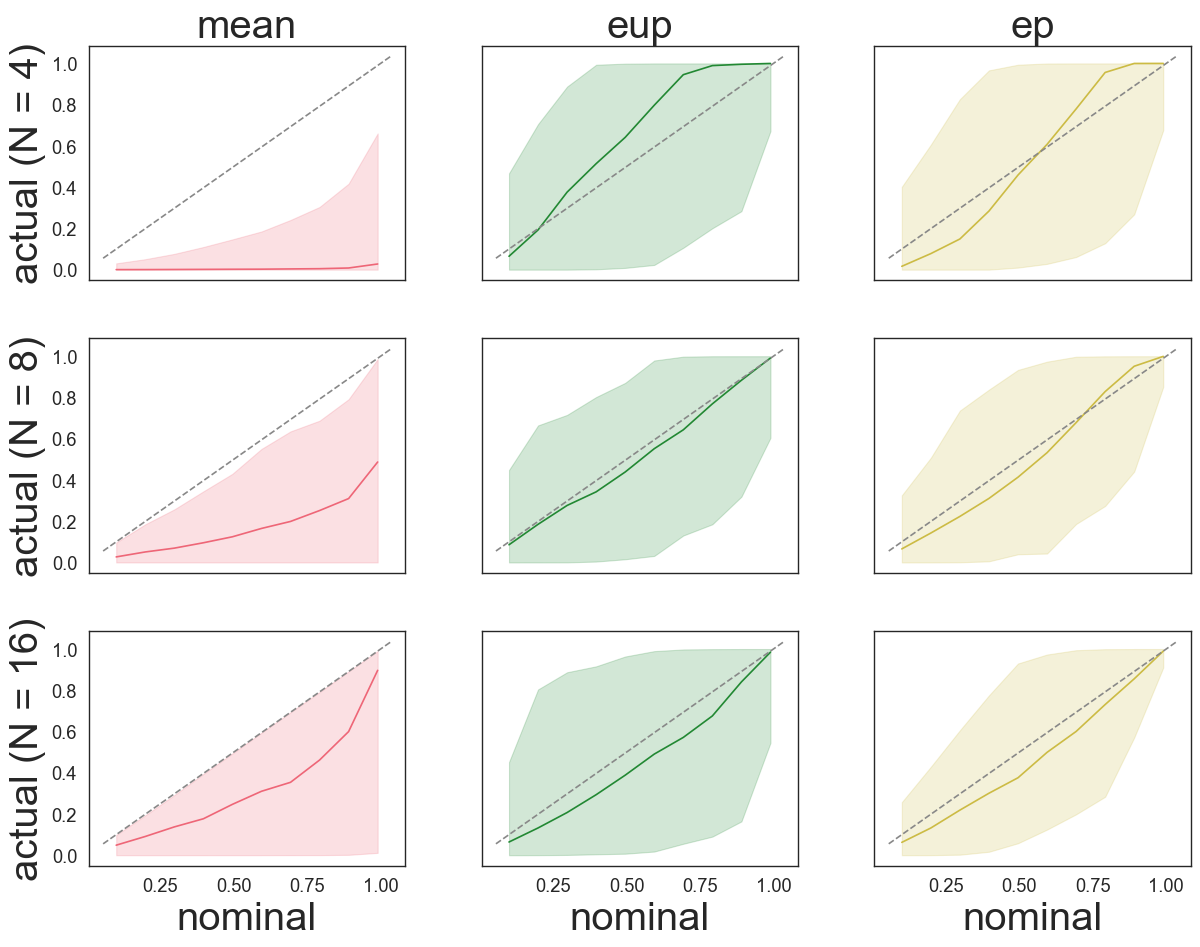

In [ ]:
ndesign = [4, 8, 16]
approx = ['mean', 'eup', 'ep']
surrogate_labels = ['gp', 'clip_gp']
plots = {}

for lbl in surrogate_labels:
    surrogate_results = results[lbl]
    plots[lbl] = smart_subplots(nrows=3, ncols=3, flatten=False)
    fig, axs = plots[lbl]

    for n_idx, n in enumerate(ndesign):
        subdir_name = f'{lbl}_N{n}'
        res = results[lbl][subdir_name]['results']
        for dist_idx, dist_name in enumerate(approx):
            ax = axs[n_idx, dist_idx]
            idx = list(res['dist_names']).index(dist_name)

            plot_coverage_curve_reps(log_coverage=res['log_coverage'][:,[idx],:], 
                                    probs=res['probs'], 
                                    names=[dist_name],
                                    colors=colors,
                                    qmin=0.05,
                                    qmax=0.95,
                                    single_plot=True,
                                    ax=ax,
                                    alpha=0.2, max_cols=3)
            
            if n_idx == 0: # first row
                ax.set_title(dist_name, fontsize=ax.title.get_fontsize() * 2)
            if n_idx != (len(ndesign)-1): # all but final row
                ax.set_xlabel(None)
                # ax.set_xticklabels([])
            else:
                ax.set_xlabel('nominal', fontsize=ax.xaxis.label.get_size() * 2)
            if dist_idx != 0: # all but first column
                ax.set_ylabel(None)
                # ax.set_yticklabels([])
            else:
                ax.set_ylabel(f'actual (N = {n})', fontsize=ax.yaxis.label.get_size() * 2)

            ax.get_legend().remove()


plots['gp'][0].savefig(output_dir / 'vsem_coverage_gp.png',
                       bbox_inches='tight')
plots['clip_gp'][0].savefig(output_dir / 'vsem_coverage_clip_gp.png',
                            bbox_inches='tight')

display(plots['gp'][0])
display(plots['clip_gp'][0])


In [ ]:
from uncprop.utils.grid import plot_coverage_curve_reps

for subdir, info in gp_results.items():
    res = info['results']
    
    # top row
    set_title = (subdir == 'clip_gp_')

    if subdir == 'clip_gp_N4':
        set_title = True

    plot_coverage = plot_coverage_curve_reps(log_coverage=res['log_coverage'], 
                                             probs=res['probs'], 
                                             names=res['dist_names'],
                                             colors=colors,
                                             qmin=0.05,
                                             qmax=0.95,
                                             single_plot=False,
                                             alpha=0.3, max_cols=3)

## Investigate specific reps

In [ ]:
subdir_name = 'clip_gp_N4'
rep_idx = 4

grid, results, log_dens, plots = summarize_rep(out_dir=out_dir,
                                               subdir_name=subdir_name,
                                               rep_idx=rep_idx,
                                               n_reps=100)